### Generic Title Placeholder

The problem we are trying to solve is brain diagnosis using AI. This requires MRI imaging which requires computer vision: STEP 1: COMPUTER VISION

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set up environment
import pandas as pd
import numpy as np
import os


from glob import glob
import cv2
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
#Pre-trained model we plan on using
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB0, VGG16
from keras import callbacks



### Read in Images

In [3]:
# Current Working Directory
cwd = os.getcwd()

#Training Images
train_no_tumor = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training/notumor/*.jpg')
train_glioma = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training/glioma/*.jpg')
train_meni = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training/meningioma/*.jpg')
train_pituitary = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training/pituitary/*.jpg')

# Test Images
test_no_tumor = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing/notumor/*.jpg')
test_glioma = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing/glioma/*.jpg')
test_meni = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing/meningioma/*.jpg')
test_pituitary = glob(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing/pituitary/*.jpg')

# Load an image
img_mpl = plt.imread(test_no_tumor[20])
img_cv2 = cv2.imread(test_no_tumor[20])

# Images are 3d shape.
img_mpl.shape, img_cv2.shape


((231, 218, 3), (231, 218, 3))

### What the Heck Does This Even Mean?

Image arrays are split up in the following way: (Height, Width, Channels) in terms of pixels.
Each image is broken down in terms of pixels and each pixel has a value with those dimensions.

### How Can We Visualize This?



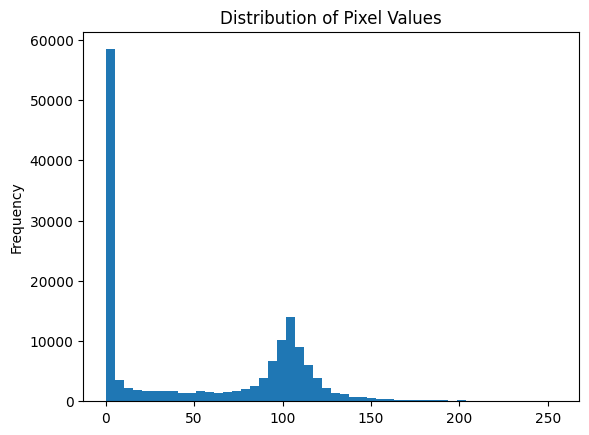

In [ ]:
# Create a histogram to show the distribution of our Pixel Values
pd.Series(img_mpl.flatten()).plot(kind = 'hist', bins = 50, title = 'Distribution of Pixel Values')
plt.show()

### Let's Display It
Using matplotlib

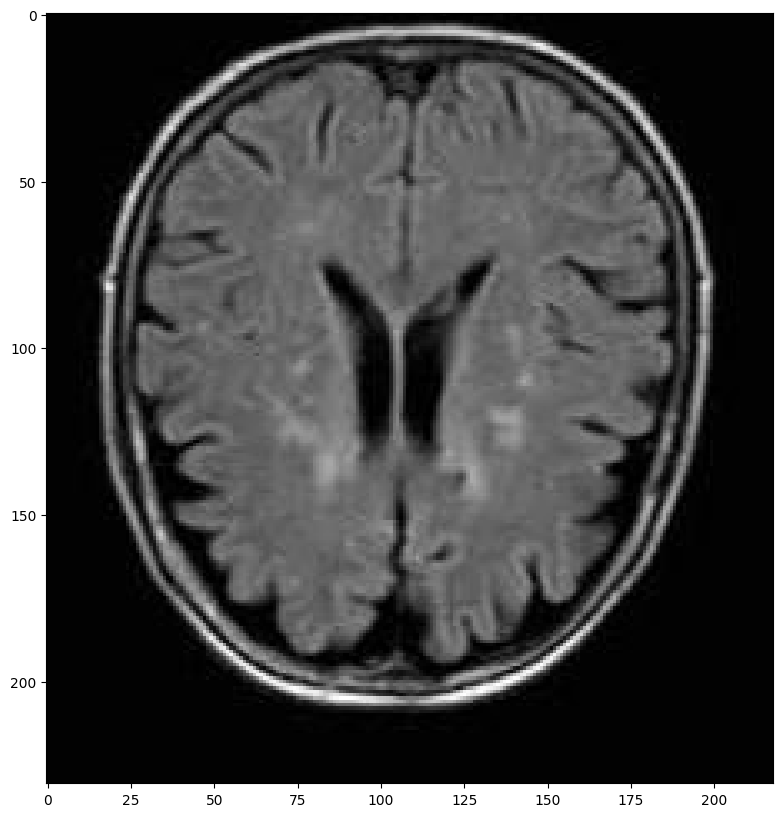

In [ ]:
# Keep the image a not gigantamasaurus size pls :)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img_mpl)
plt.show()

## RGB Representation
As shown before, there are 3 channels for our images. We will display those channels

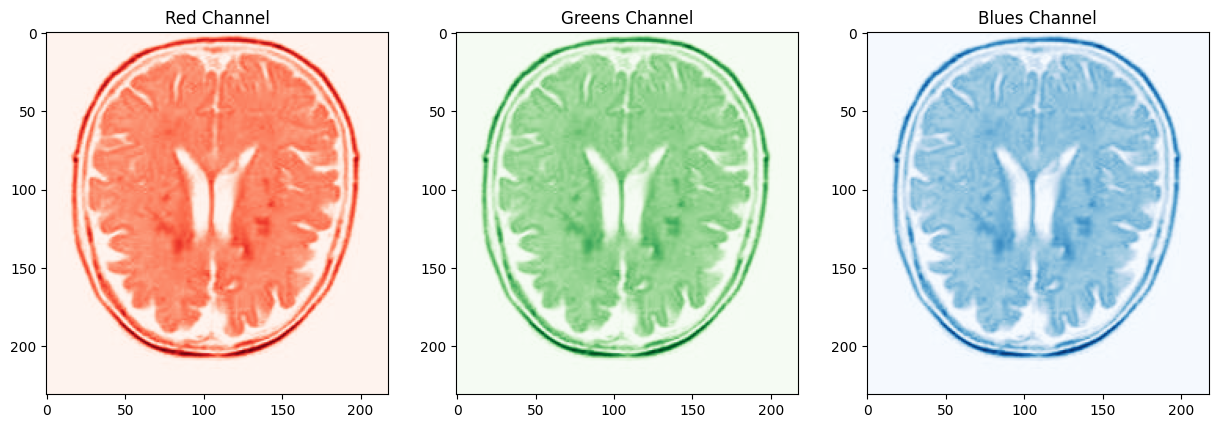

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))
axis[0].imshow(img_mpl[:,:,0], cmap='Reds')
axis[1].imshow(img_mpl[:,:,1], cmap='Greens')
axis[2].imshow(img_mpl[:,:,2], cmap='Blues')
axis[0].set_title('Red Channel')
axis[1].set_title('Greens Channel')
axis[2].set_title('Blues Channel')
plt.show()

## Finding pixel intensity
With tumors, we believe that tumors will have distinct spots that stand out compared to a brain with no tumors. We will try to find correlation.

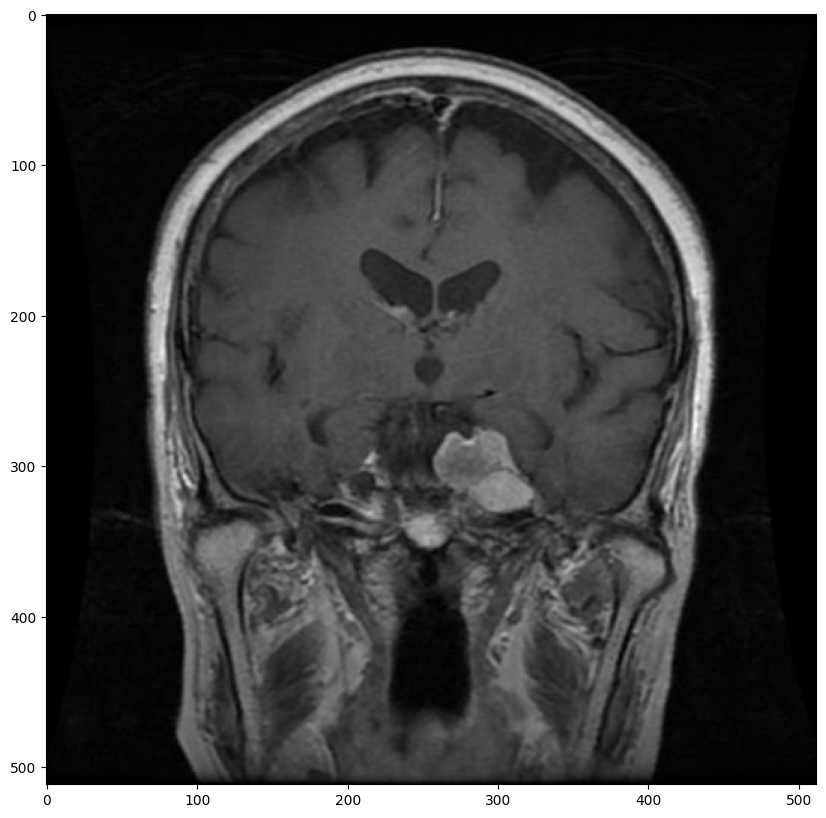

In [ ]:
tumor_img = cv2.imread(train_meni[4])
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(tumor_img)
plt.show()

In [ ]:
#Function to compute pixel intensity of an image
def pixel_intensity(photos):
    return np.mean(photos) #return the average pixel intensity of image

#Function to go through images in tumor folders to append to an array
def image_pixel_processing(img_paths, category, data_array):
    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            avg_intensity = pixel_intensity(img)
            data_array.append([avg_intensity, category])


pixel_data = []
image_pixel_processing(train_meni, "Tumor-Meni", pixel_data)
image_pixel_processing(train_glioma, "Tumor-Glioma", pixel_data)
image_pixel_processing(train_pituitary, "Tumor-Pituitary", pixel_data)
image_pixel_processing(train_no_tumor, "No Tumor", pixel_data)

data_frame = pd.DataFrame(pixel_data, columns=["Average_Intensity", "Label"])

print(data_frame.groupby("Label").describe())

                Average_Intensity                                              \
                            count       mean        std        min        25%   
Label                                                                           
No Tumor                   1595.0  60.723461  21.244006   9.768337  44.079515   
Tumor-Glioma               1321.0  32.711430   8.564805  13.692505  26.012524   
Tumor-Meni                 1339.0  43.482108  14.308397  18.228062  34.985043   
Tumor-Pituitary            1457.0  49.267893   8.223707  24.695900  44.082733   

                                                   
                       50%        75%         max  
Label                                              
No Tumor         57.007125  74.025510  125.144783  
Tumor-Glioma     31.559185  38.592079   68.363167  
Tumor-Meni       40.824043  46.878197  137.764303  
Tumor-Pituitary  49.823555  54.253468  102.333716  


As we can see, MRI scans with no tumor have a higher pixel intensity than MRI scans with tumors. MRI Scans of the pituitary show the highest pixel density, and the Meni area appears to have the second highest average pixel intensity with Glioma having the lowest intensity, but all three do not have as high an average pixel intensity as MRI scans with no tumors.

## Check for number of photos

To ensure that we don't have an imbalance of photots, we will check to see how many photos there are per type of MRI photo.

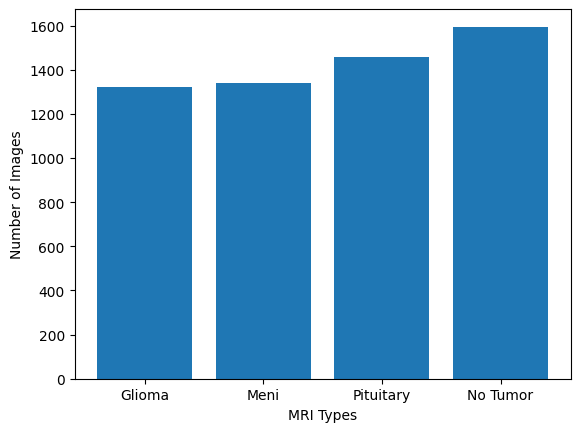

In [ ]:
#array to hold names of what type of photo is being used
training_images = ["Glioma", "Meni", "Pituitary", "No Tumor"]
#array to hold number of photos per folder of specific MRI type
folder_sizes = []
folder_sizes.append(len(train_glioma))
folder_sizes.append(len(train_meni))
folder_sizes.append(len(train_pituitary))
folder_sizes.append(len(train_no_tumor))
#Graph for number of photos per MRI type
plt.bar(training_images, folder_sizes)
plt.xlabel("MRI Types")
plt.ylabel("Number of Images")
plt.show()

As we can see, there is a decent distribution of photos. Pituitary and No tumor images do have more than glioma and meni, but not too many. There may be some undersampling for no tumors, but we will see how things go.

## Modifying the image

To help with our machine, it would be good for it to have images modified so that our AI can handle different possible looks for our images.

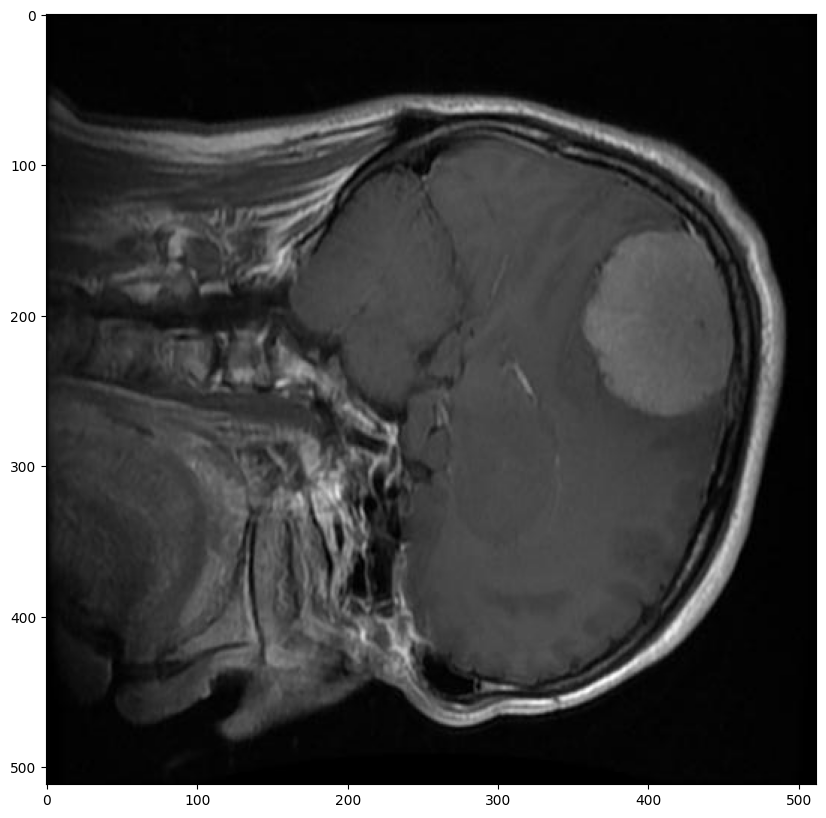

In [ ]:
#augment image via rotating image
def image_augmentation(img_paths):
  mod_photos = []
  for img_path in img_paths:
    img = cv2.imread(img_path)
    img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    mod_photos.append(img_rotated)
  return mod_photos

meni_rotated = image_augmentation(train_meni)

#Print example image
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(meni_rotated[20])
plt.show()

With the above image, we have rotated our image. Augmenting our image via rotation and also grey-scaling and blurring could help our model handle different possible image layouts.

## Taking in images with Tensorflow

for our project, we will be using Tensorflow to read in our images and feed them to our model.

In [ ]:
# Keras defaults batch size to 32 and image size to 256 by 256; ideal for our use
train_data = tf.keras.utils.image_dataset_from_directory(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training')
test_data = tf.keras.utils.image_dataset_from_directory(cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing')

# Numpy iterator
train_iterator = train_data.as_numpy_iterator()
test_iterator = test_data.as_numpy_iterator()
# Our batch size is 32 by default as per keras
batch = train_iterator.next()
batch_test = test_iterator.next()

# Images represented as numpy arrays
batch[0].shape

# Image labels. The array given is the labels in alphabetical order: 0 = Glioma, 1: Meningioma, 2: Notumor, 3: Pituitary
batch[1]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


array([2, 0, 2, 1, 1, 0, 1, 2, 1, 3, 1, 2, 0, 3, 2, 0, 3, 1, 2, 2, 3, 2,
       3, 2, 3, 2, 0, 1, 2, 2, 3, 2], dtype=int32)

## Data Pre-Processing

I will be doing pre-processing on our model to make it easier for our model to handle.

In [8]:
#Image pre-processing and augmentation
generator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = .30
)

train = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "training"
)

val = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

#Implement Early Stopping and Learning Rate Reduction when accuracy growth plateus
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, restore_best_weights = True)
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.5, patience = 2, min_lr=1e-6)

Found 4000 images belonging to 4 classes.
Found 1712 images belonging to 4 classes.


## Implementing EfficientNetB3 model

To try to improve performance, we will use a pre-trained model for our work. Pre-trained models will already have training done on it, but now we can add in our own data, and tweak one of the layers to make it work better for MRI scans. For this project, we will use EfficientNet.

In [4]:
#Log data for execution
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
#create base model that we'll add to later
base = EfficientNetB0(weights="imagenet", include_top = False, input_shape=(224, 224, 3))

base.trainable = False
for layers in base.layers[-20:]:
  layers.trainable = True

model = Sequential()
model.add(base)
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Flatten())
model.add(Dense(4, activation="sigmoid"))
#compile the model and show the summary
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 3, 3, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 3, 3, 256)           │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 3, 3, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 4)                   │           4,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,420,135 (16.86 MB)

 Trainable params: 1,718,964 (6.56 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

### Trying a smaller dataset

We will briefly try using a smaller dataset to see what happens. This will be done on our initiall EfficientNetB3 model. Do not run this section of code normally. Use only if you wanna try a smaller data set

In [5]:
#Image pre-processing and augmentation
generator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 45,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode="nearest",
    brightness_range = [0.5,1.5],
    validation_split = .90
)

train = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "training"
)

val = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

#Implement Early Stopping and Learning Rate Reduction when accuracy growth plateus
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, restore_best_weights = True)
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.5, patience = 2, min_lr=1e-6)

Found 573 images belonging to 4 classes.
Found 5139 images belonging to 4 classes.


In [ ]:
# Adjust epochs and batches
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stop, reduce_learning])

Epoch 1/20


KeyboardInterrupt: 

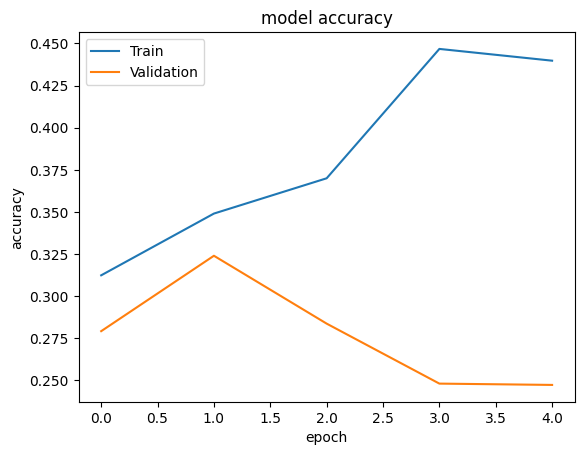

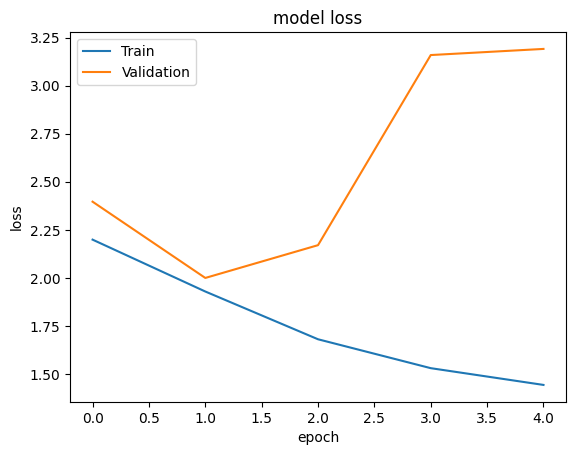

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test = test_datagen.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Don't shuffle for accurate predictions
)

test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy}')

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 375s 9s/step - accuracy: 0.0719 - loss: 2.4932
Test Accuracy: [2.0412938594818115, 0.3012967109680176]


## This is the end of trying a smaller subset

In [ ]:
# Adjust epochs and batches
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stop, reduce_learning])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 572s 5s/step - accuracy: 0.2677 - loss: 3.5089 - val_accuracy: 0.2792 - val_loss: 2.6770 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 564s 5s/step - accuracy: 0.3341 - loss: 2.4781 - val_accuracy: 0.3131 - val_loss: 2.0170 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.3546 - loss: 1.8736 - val_accuracy: 0.2792 - val_loss: 4.2738 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 615s 5s/step - accuracy: 0.3815 - loss: 1.5674 - val_accuracy: 0.2523 - val_loss: 1.5974 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 627s 5s/step - accuracy: 0.3776 - loss: 1.4240 - val_accuracy: 0.2792 - val_loss: 3.4956 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.3913 - loss: 1.3326 - val_accuracy: 0.2383 - val_loss: 1.4907 - learning_rate: 0.0010
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - accuracy: 0.4008 - loss: 1.

Here we will save our compiled model and then graph out the loss and accuracy, comparing training accuracy and validation accuracy.

In [ ]:
#Save our model
model.save('efficientnetb0.keras')

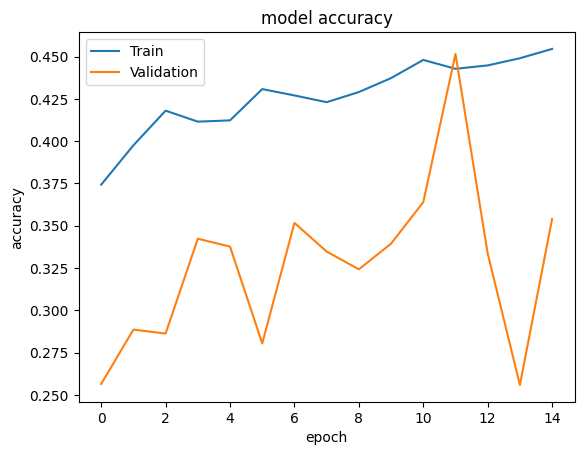

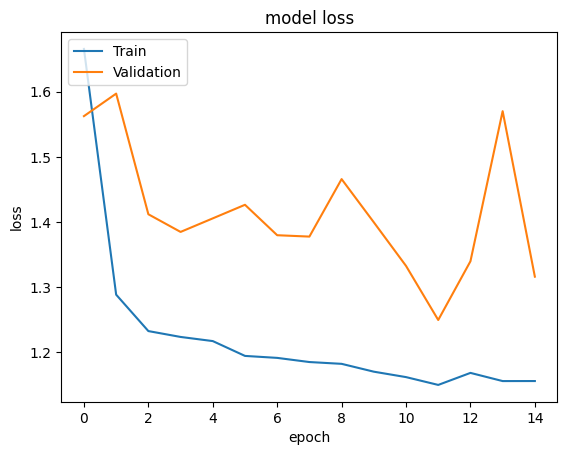

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here we will have our model try to predict our test images as well as evaluate it's accuracy on the test data.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test = test_datagen.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Don't shuffle for accurate predictions
)

# Predict
predictions = model.predict(test)

print(predictions)

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step
[[0.25603476 0.23356268 0.1901793  0.3202233 ]
 [0.29137665 0.27919543 0.14157774 0.2878502 ]
 [0.30088535 0.2976042  0.1281171  0.27339336]
 ...
 [0.17170425 0.18957315 0.32949936 0.3092232 ]
 [0.17444013 0.25146708 0.30467877 0.269414  ]
 [0.1395379  0.13547225 0.3951037  0.3298861 ]]


In [ ]:
test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.3185 - loss: 1.3278
Test Accuracy: [1.177699327468872, 0.5133485794067383]


As we can see, the accuracy on the test data is not perfect, there is definitely overfitting with this model. We will now try to set our model to unfreeze the last couple of layers, allowing for more fine-tuning.

In [ ]:
for layers in base.layers[-20:]:
  layers.trainable = True

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback, early_stop, reduce_learning])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │         884,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,752,179 (44.83 MB)

 Trainable params: 4,341,668 (16.56 MB)

 Non-trainable params: 7,410,511 (28.27 MB)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1085s 8s/step - accuracy: 0.3627 - loss: 1.3522 - val_accuracy: 0.3890 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.4267 - loss: 1.1950 - val_accuracy: 0.3429 - val_loss: 1.3556 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1002s 8s/step - accuracy: 0.4330 - loss: 1.1882 - val_accuracy: 0.2605 - val_loss: 1.4542 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1004s 8s/step - accuracy: 0.4367 - loss: 1.1691 - val_accuracy: 0.2862 - val_loss: 1.7823 - learning_rate: 5.0000e-04


We will now save and graph our retrained EfficientNetB3 model

In [ ]:
#Save our model
model.save('efficientnetb3_retrained.keras')

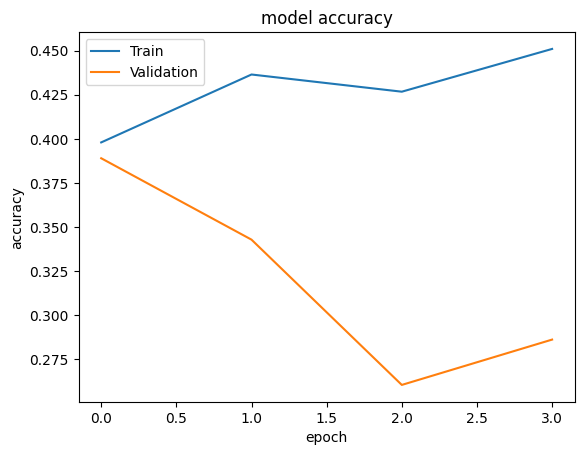

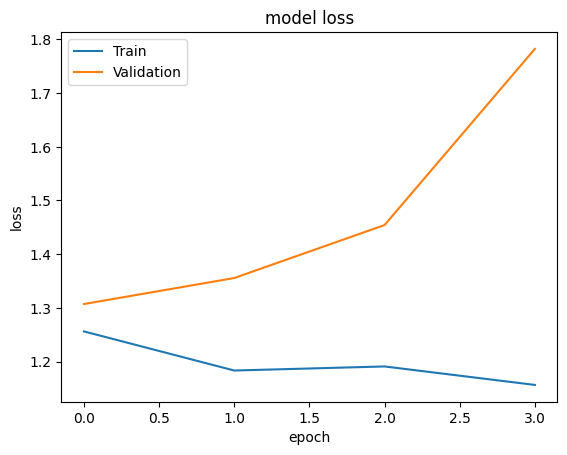

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We will now try to predict and evaluate our retrained model on the test data.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test = test_datagen.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Don't shuffle for accurate predictions
)

# Predict
predictions = model.predict(test)

print(predictions)

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step
[[0.21544008 0.15755717 0.2766766  0.35032618]
 [0.26813206 0.20879482 0.20449549 0.31857756]
 [0.2943275  0.2338293  0.17379531 0.29804784]
 ...
 [0.18629707 0.13094719 0.32044363 0.3623121 ]
 [0.21511751 0.15792477 0.27647567 0.35048208]
 [0.1527887  0.10547332 0.37524822 0.36648974]]


In [ ]:
test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.1606 - loss: 1.4423
Test Accuracy: [1.2763036489486694, 0.41647598147392273]


## VGG Transferrence Model
As seen above, there is a lot of overfitting. To try a different approach, we will try to use the VGG premade model and apply transference learning to see how it does compared to EfficientNet.

In [ ]:
#Image pre-processing and augmentation, updated for VGG requirements
generator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 45,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode="nearest",
    brightness_range = [0.5,1.5],
    validation_split = .30
)

train = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    subset = "training"
)

val = generator.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Training',
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    subset = "validation"
)

#Implement Early Stopping and Learning Rate Reduction when accuracy growth plateus
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, restore_best_weights = True)
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.5, patience = 2, min_lr=1e-6)

#VGG13 use
vgg_base = VGG16(weights="imagenet", include_top = False, input_shape=(224, 224, 3))

vgg_base.trainable = False #Frezze all layers

model2 = Sequential()

model2.add(vgg_base)
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) #compile the model
model2.summary()

vgg_history = model2.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback, early_stop, reduce_learning])

Found 4000 images belonging to 4 classes.
Found 1712 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7, 7, 512)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │         100,356 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,077,700 (57.52 MB)

 Trainable params: 363,012 (1.38 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3727s 30s/step - accuracy: 0.5576 - loss: 1.2965 - val_accuracy: 0.6799 - val_loss: 0.9165 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3638s 29s/step - accuracy: 0.8212 - loss: 0.4512 - val_accuracy: 0.7190 - val_loss: 0.9348 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3688s 29s/step - accuracy: 0.8457 - loss: 0.3911 - val_accuracy: 0.7383 - val_loss: 0.8092 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3644s 29s/step - accuracy: 0.8690 - loss: 0.3837 - val_accuracy: 0.7523 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3654s 29s/step - accuracy: 0.8681 - loss: 0.3469 - val_accuracy: 0.7424 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3678s 29s/step - accuracy: 0.8801 - loss: 0.3350 - val_accuracy: 0.7728 - val_loss: 0.8510 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3691s 30s/step - accuracy: 0.8

We will now save our model and graph out accuracy and loss for VGG16 based model

In [ ]:
#Save our model
model2.save('vgg16.keras')

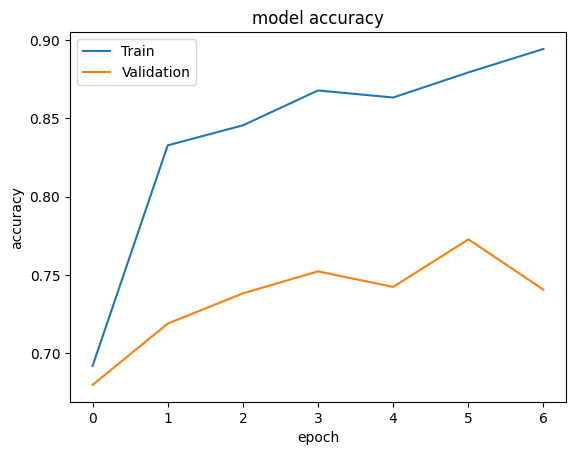

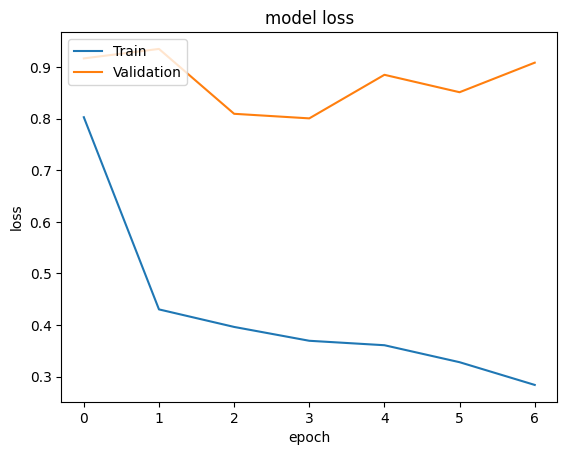

In [ ]:
# summarize history for accuracy
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We will now try to use our model to predict our test data, and then evaluate it's accuracy on the test data.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test = test_datagen.flow_from_directory(
    cwd + '/drive/MyDrive/CPSC 499 Final Project/Resources/Datasets/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Don't shuffle for accurate predictions
)

# Predict
predictions = model2.predict(test)

print(predictions)

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 825s 20s/step
[[6.3590831e-01 1.3424819e-02 2.8507549e-01 6.5591373e-02]
 [2.5492808e-01 1.2470395e-01 2.0894405e-02 5.9947360e-01]
 [9.8920298e-01 7.4111302e-03 4.3376206e-04 2.9522090e-03]
 ...
 [1.0034428e-02 8.7844446e-02 4.9787727e-03 8.9714241e-01]
 [2.1655306e-02 5.0268050e-02 1.8783377e-03 9.2619836e-01]
 [7.8570558e-04 7.4131042e-03 2.1453369e-04 9.9158669e-01]]


In [ ]:
test_accuracy = model2.evaluate(test)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 818s 20s/step - accuracy: 0.7226 - loss: 0.8092
Test Accuracy: [0.6333369016647339, 0.7986270189285278]


## Load B0 model and rerun it

In [12]:
new_model = tf.keras.models.load_model('efficientnetb0.keras')

# Show the model architecture
new_model.summary()

new_model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stop, reduce_learning])

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 3, 3, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 3, 3, 256)           │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 3, 3, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 4)                   │           4,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,858,065 (29.98 MB)

 Trainable params: 1,718,964 (6.56 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

 Optimizer params: 3,437,930 (13.11 MB)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.4305 - loss: 1.1670 - val_accuracy: 0.3347 - val_loss: 1.4233 - learning_rate: 2.5000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.4586 - loss: 1.1396 - val_accuracy: 0.2757 - val_loss: 1.6656 - learning_rate: 2.5000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.4333 - loss: 1.1627 - val_accuracy: 0.4340 - val_loss: 1.3374 - learning_rate: 2.5000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - accuracy: 0.4542 - loss: 1.1488 - val_accuracy: 0.4702 - val_loss: 1.3118 - learning_rate: 2.5000e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - accuracy: 0.4497 - loss: 1.1251 - val_accuracy: 0.3633 - val_loss: 1.4846 - learning_rate: 2.5000e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.4252 - loss: 1.1726 - val_accuracy: 0.2810 - val_loss: 1.6531 - learning_rate: 2.5000e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - acc

In [14]:
#Save our model
new_model.save('efficientnetb0.keras')